Puntuación de Silhouette para DBSCAN: 0.6308350444654197
Clústeres detectados: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(-1)}
Datos antes del filtrado: 149
Datos después del filtrado: 103


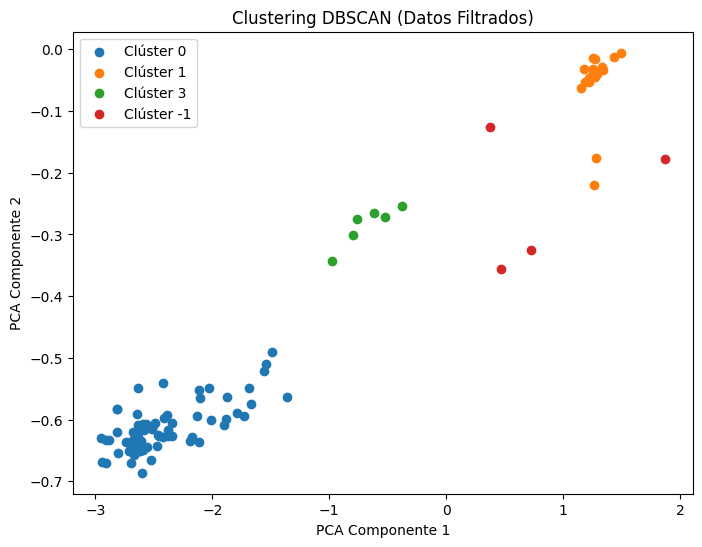

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\monts\OneDrive\Escritorio\UAA\.venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Informe de clasificación para Random Forest:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        13
           1       0.38      0.43      0.40         7
           2       0.78      0.70      0.74        10

    accuracy                           0.63        30
   macro avg       0.62      0.61      0.61        30
weighted avg       0.65      0.63      0.64        30

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Informe de clasificación para XGBoost:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.38      0.43      0.40         7
           2       0.70      0.70      0.70        10

    accuracy                           0.63        30
   macro avg       0.61      0.61      0.61        30
weighted avg       0.65      0.63      0.64        30

Informe de clasificación para Logistic Regression:
              precision    recall  f1-sco

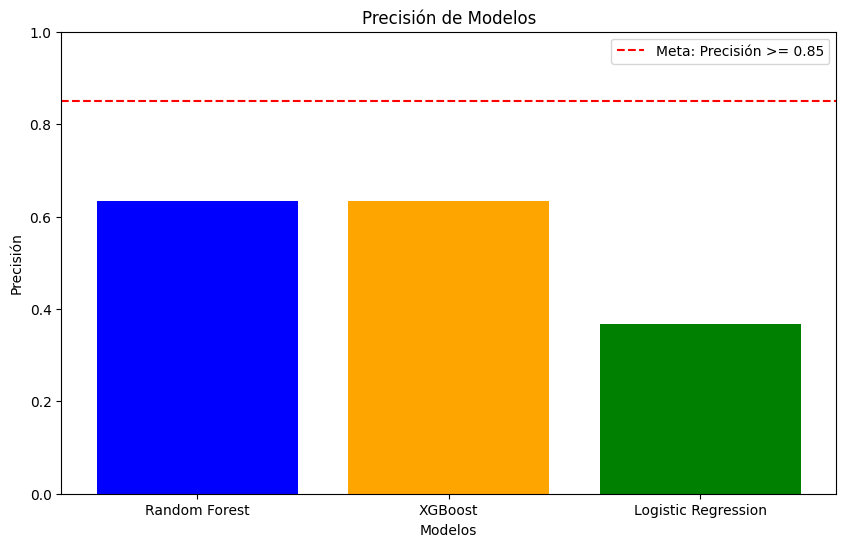

In [39]:
# Importar las bibliotecas necesarias
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy.stats import uniform
from xgboost import XGBClassifier

# Establecer la variable de entorno para evitar la advertencia de fuga de memoria en KMeans
os.environ['OMP_NUM_THREADS'] = '1'

# Cargar el dataset
dataset = pd.read_excel("C:/Users/monts/OneDrive/Escritorio/UAA/Inteligencia Artificial/VIH/dataset_VIH.xlsx")

# Usar todas las columnas excepto las irrelevantes
X = dataset.drop(columns=["aminoacido", "sumatoria"])  # Usar todas las columnas de propiedades moleculares

# Combinar clases 1 y 2 en una nueva clase "1-2"
y = dataset['clase'].str.strip()  # Columna objetivo, eliminar espacios en blanco
y_combined = y.replace({'1': '1-2', '2': '1-2'})  # Combinar clases

# Reemplaza valores nulos con 0 en las características numéricas
X = X.fillna(0)

# Asegurarse de que todas las columnas de X son numéricas
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(0)

# Normalizar los datos para mejorar la distribución
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir las etiquetas a valores numéricos usando LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_combined)

# Reducción de dimensionalidad con PCA (2 componentes para visualización)
pca = PCA(n_components=2, random_state=42)
X_pca_scaled = pca.fit_transform(X_scaled)

# **Inicio del Aprendizaje No Supervisado**
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan_clusters = dbscan.fit_predict(X_pca_scaled)

if len(set(dbscan_clusters)) > 1:
    silhouette_dbscan = silhouette_score(X_pca_scaled, dbscan_clusters)
else:
    silhouette_dbscan = "No es posible calcular (1 solo clúster)"

print("Puntuación de Silhouette para DBSCAN:", silhouette_dbscan)
print("Clústeres detectados:", set(dbscan_clusters))

filtered_indices = np.where(
    (X_pca_scaled[:, 0] > -3) & (X_pca_scaled[:, 0] < 3) & 
    (X_pca_scaled[:, 1] > -3) & (X_pca_scaled[:, 1] < 3)
)
filtered_data = X_pca_scaled[filtered_indices]
filtered_clusters = dbscan_clusters[filtered_indices]

print("Datos antes del filtrado:", X_pca_scaled.shape[0])
print("Datos después del filtrado:", filtered_data.shape[0])

plt.figure(figsize=(8, 6))
for cluster_id in set(filtered_clusters):
    cluster_points = filtered_data[filtered_clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Clúster {cluster_id}")
plt.title("Clustering DBSCAN (Datos Filtrados)")
plt.xlabel("PCA Componente 1")
plt.ylabel("PCA Componente 2")
plt.legend()
plt.show()
# **Fin del Aprendizaje No Supervisado**

# **Inicio del Aprendizaje Supervisado**
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Entrenar un modelo de Random Forest (ajuste más exhaustivo)
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

random_search_rf = RandomizedSearchCV(rf, param_distributions=param_grid_rf,
                                      n_iter=50, cv=5,
                                      n_jobs=-1, verbose=2,
                                      random_state=42)
random_search_rf.fit(X_train_balanced, y_train_balanced)

y_pred_rf = random_search_rf.best_estimator_.predict(X_test)
print("Informe de clasificación para Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Entrenar un modelo XGBoost (ajuste más exhaustivo)
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')

param_dist_xgb = {
    'n_estimators': [100, 150, 200],
    'learning_rate': uniform(0.01, 0.2), 
    'max_depth': [3, 5, 7],
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
}

random_search_xgb = RandomizedSearchCV(xgb,
                                        param_distributions=param_dist_xgb,
                                        n_iter=50,
                                        cv=5,
                                        n_jobs=-1,
                                        verbose=2,
                                        random_state=42)
random_search_xgb.fit(X_train_balanced, y_train_balanced)

y_pred_xgb = random_search_xgb.best_estimator_.predict(X_test)
print("Informe de clasificación para XGBoost:")
print(classification_report(y_test, y_pred_xgb))

# Probar con Logistic Regression para comparar resultados
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_balanced, y_train_balanced)
y_pred_logreg = logreg.predict(X_test)

print("Informe de clasificación para Logistic Regression:")
print(classification_report(y_test, y_pred_logreg))

# Comparar precisiones y mostrar el mejor modelo
precision_scores = {
    "Random Forest": random_search_rf.best_estimator_.score(X_test, y_test),
    "XGBoost": random_search_xgb.best_estimator_.score(X_test, y_test),
    "Logistic Regression": logreg.score(X_test, y_test),
}

best_model_name = max(precision_scores, key=precision_scores.get)
best_model_score = precision_scores[best_model_name]

print(f"\nMejor modelo: {best_model_name} con precisión: {best_model_score:.2f}")

# Graficar las precisiones en un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(precision_scores.keys(), precision_scores.values(), color=['blue', 'orange', 'green'])
plt.title('Precisión de Modelos')
plt.xlabel('Modelos')
plt.ylabel('Precisión')
plt.ylim(0.0, 1.0)  
plt.axhline(y=0.85, color='red', linestyle='--', label='Meta: Precisión >= 0.85')
plt.legend()
plt.show()

In [34]:
# Definir las clases verdaderas (esto depende de cómo estén representadas en tu conjunto de datos)
# En este caso, supongamos que las categorías verdaderas son CCR5, CXCR4 o Dual-tropico.
# Digamos que estas clases son representadas por los valores 0, 1, 2 en tu variable 'y_encoded'
clases_verdaderas = [0, 1, 2]  # Definir las clases que consideramos "verdaderas" (tropismos)
# Función para comparar las predicciones
def comparar_predicciones(y_true, y_pred, clases_verdaderas):
    # Verificar si las predicciones corresponden a las clases verdaderas usando numpy.isin()
    predicciones_verdaderas = (y_pred == y_true) & np.isin(y_true, clases_verdaderas)
    predicciones_falsas = ~(y_pred == y_true) & np.isin(y_true, clases_verdaderas)
    
    # Contar los verdaderos y falsos positivos
    verdaderos_positivos = predicciones_verdaderas.sum()
    falsos_positivos = predicciones_falsas.sum()

    print(f"Verdaderos Positivos (VVP): {verdaderos_positivos}")
    print(f"Falsos Positivos (VNP): {falsos_positivos}")
    print(f"Total Predicciones: {len(y_true)}")
    return verdaderos_positivos, falsos_positivos

# **Evaluar las predicciones de Random Forest**
print("Evaluación para Random Forest:")
y_pred_rf_verdaderos, y_pred_rf_falsos = comparar_predicciones(y_test, y_pred_rf, clases_verdaderas)
print("\n")

# **Evaluar las predicciones de XGBoost**
print("Evaluación para XGBoost:")
y_pred_xgb_verdaderos, y_pred_xgb_falsos = comparar_predicciones(y_test, y_pred_xgb, clases_verdaderas)
print("\n")
# **Evaluar las predicciones de Logistic Regression**
print("Evaluación para Logistic Regression:")
y_pred_logreg_verdaderos, y_pred_logreg_falsos = comparar_predicciones(y_test, y_pred_logreg, clases_verdaderas)


Evaluación para Random Forest:
Verdaderos Positivos (VVP): 19
Falsos Positivos (VNP): 11
Total Predicciones: 30


Evaluación para XGBoost:
Verdaderos Positivos (VVP): 18
Falsos Positivos (VNP): 12
Total Predicciones: 30


Evaluación para Logistic Regression:
Verdaderos Positivos (VVP): 11
Falsos Positivos (VNP): 19
Total Predicciones: 30
